# Project Definition

The goal of this project is to practice the application of Decision Tree and Random Forest Classifiers. The data used for this project will be the publically available loan data set from LendingClub.com. 

We will be using lending data from 2007-2010 and will be trying to classify and predict whether or not the borrower paid back their loan in full.

Here are what the columns represent:
* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

# Import Libraries

In [37]:
#data manipulation
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#metrics
from sklearn.metrics import classification_report, confusion_matrix

# Data Preparation

In [3]:
#read in loan data csv as loans dataframe
loans = pd.read_csv('loan_data.csv')
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


# Exploratory Data Analysis

Now that we've got a basic idea of what the data is, let's visualize it using a couple different plots to get an idea of how the features interact.

Let's see what FICO scores get approved, and which get denied.

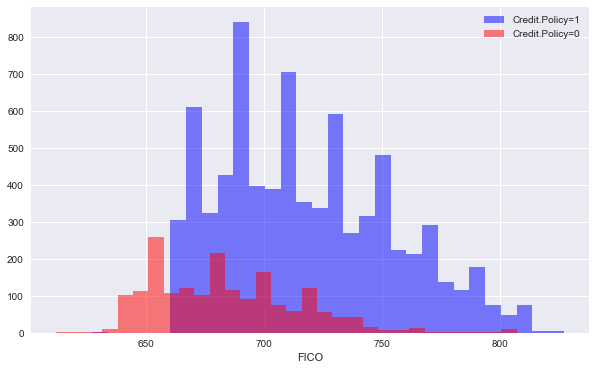

In [5]:
plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Credit.Policy=1')
loans[loans['credit.policy']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='Credit.Policy=0')
plt.legend()
plt.xlabel('FICO')

The histogram shows that there seems to be a hard cutoff around 660 and that FICO score isn't the only factor in determining Credit Policy approval.

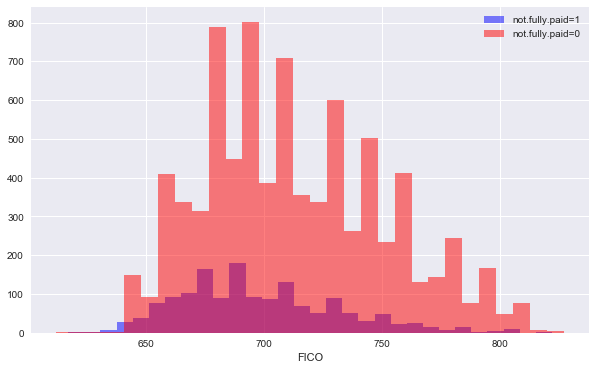

In [6]:
#overlap histograms by lowering the alpha value
plt.figure(figsize=(10,6))
loans[loans['not.fully.paid']==1]['fico'].hist(alpha=0.5, color='blue',
                                              bins=30, label='not.fully.paid=1')
loans[loans['not.fully.paid']==0]['fico'].hist(alpha=0.5, color='red',
                                              bins=30, label='not.fully.paid=0')
plt.legend()
plt.xlabel('FICO')

It seems like FICO Score isn't a strong indicator of if they pay off their loans either. 

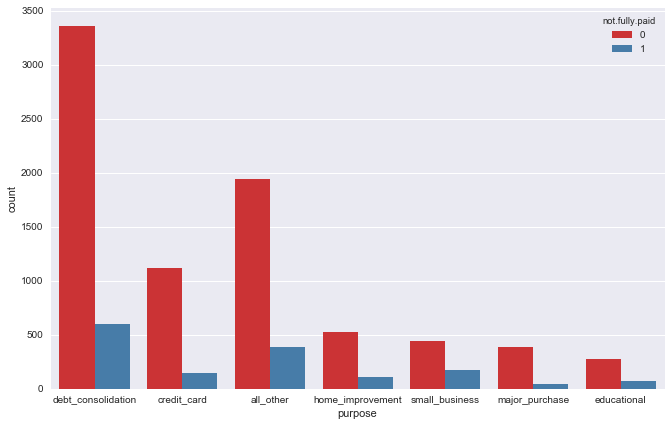

In [9]:
#countplot showing the amt. of loans by purpose and the division of paid/unpaid loans
plt.figure(figsize=(11,7))
sns.countplot(x='purpose', hue='not.fully.paid', data=loans, palette='Set1')

Nothing stands out as a definite indicator on loan repayment, however, we do see some variation. Loans taken out for small businesses have a higher repayment rate than other purposes.

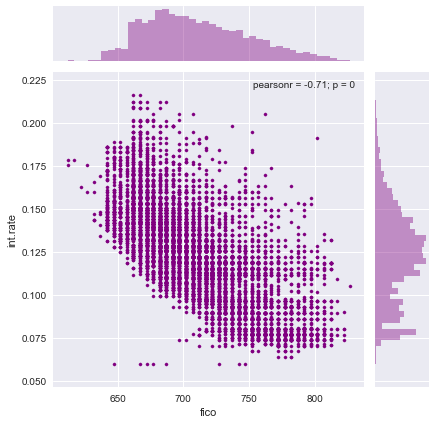

In [26]:
#Fico Score vs. Interest Rate
sns.jointplot(x='fico',y='int.rate',data=loans,color='purple', s=10)

Pretty standard distribution of FICO score vs. Interest Rate. The higher the score, the higher the probability that the interest rate will be lower. Most people sit around 650-700 FICO Score and 12.5-15% interest rate.

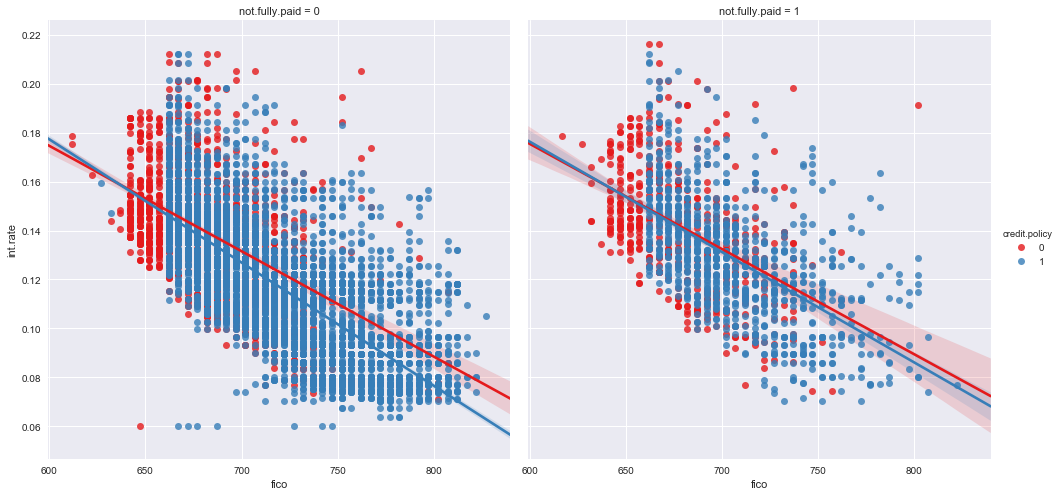

In [34]:
plt.figure(figsize=(11,7))
sns.lmplot(y='int.rate', x='fico', data=loans, hue='credit.policy',
           col='not.fully.paid', palette='Set1', size=7)

# Making Predictions

## Categorical Features

Although most of our data is ready to be used to train a model, the purpose column is filled with categorical data. 

We'll need to transform them using dummy variables so sklearn will be able to understand them.

In [36]:
#columns to be converted
cat_feats = ['purpose']

#use get dummies to convert, pass in cat_feats list, 
#drop the first column to prevent multi-colinearity
final_data = pd.get_dummies(loans,columns=cat_feats,drop_first=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 19 columns):
credit.policy                 9578 non-null int64
int.rate                      9578 non-null float64
installment                   9578 non-null float64
log.annual.inc                9578 non-null float64
dti                           9578 non-null float64
fico                          9578 non-null int64
days.with.cr.line             9578 non-null float64
revol.bal                     9578 non-null int64
revol.util                    9578 non-null float64
inq.last.6mths                9578 non-null int64
delinq.2yrs                   9578 non-null int64
pub.rec                       9578 non-null int64
not.fully.paid                9578 non-null int64
purpose_credit_card           9578 non-null uint8
purpose_debt_consolidation    9578 non-null uint8
purpose_educational           9578 non-null uint8
purpose_home_improvement      9578 non-null uint8
purpose_major_purchase        9

## Training a Decision Tree Model

In [39]:
#split data into features and labels
X = final_data.drop('not.fully.paid',axis=1)
y = final_data['not.fully.paid']

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [40]:
#create decision tree object
dtree = DecisionTreeClassifier()

#fit model to training set
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [44]:
#use model to predict labels using X test set
dtpred = dtree.predict(X_test)

print(classification_report(y_test, dtpred))
print('\n')
print(confusion_matrix(y_test, dtpred))

             precision    recall  f1-score   support

          0       0.85      0.82      0.84      2431
          1       0.19      0.24      0.21       443

avg / total       0.75      0.73      0.74      2874



[[1992  439]
 [ 338  105]]


## Training a Random Forest Model

In [45]:
#create random forest object
rfc = RandomForestClassifier(n_estimators=600)

#fit model to training set
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [46]:
rfcpred = rfc.predict(X_test)

print(classification_report(y_test, rfcpred))
print('\n')
print(confusion_matrix(y_test, rfcpred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92      2431
          1       0.57      0.03      0.05       443

avg / total       0.81      0.85      0.78      2874



[[2422    9]
 [ 431   12]]


While the Random Forest model performed better one average, the decision tree model did have its strengths.

When observing the recall for each class for the models, neither class did very well however, the decision tree scored 24% on recall of (1) while the Random Forest scored 3%. So, it all depends on the metric the user is trying to optimize.